In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [46]:
dataset = pd.read_csv('../../dataset/final_dataset.csv')
dataset.head(10)

,Unnamed: 0,Time,Day ahead forecast,Hour ahead forecast,Current demand,Time.1,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other
0,0,00:00,23437.0,22290.0,22216.0,00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0
1,1,00:05,22363.0,22089.0,22106.0,00:05,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0
2,2,00:10,22363.0,22089.0,22130.0,00:10,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0
3,3,00:15,22363.0,22089.0,22040.0,00:15,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0
4,4,00:20,22363.0,21867.0,21963.0,00:20,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0
5,5,00:25,22363.0,21867.0,21867.0,00:25,0.0,2874.0,992.0,379.0,223.0,205.0,11.0,2271.0,6926.0,1840.0,25.0,6302.0,0.0
6,6,00:30,22363.0,21867.0,21792.0,00:30,0.0,2845.0,993.0,379.0,223.0,203.0,11.0,2273.0,6919.0,1845.0,38.0,6270.0,0.0
7,7,00:35,22363.0,21626.0,21731.0,00:35,0.0,2807.0,993.0,378.0,224.0,203.0,11.0,2273.0,6885.0,1843.0,40.0,6263.0,0.0
8,8,00:40,22363.0,21626.0,21666.0,00:40,0.0,2763.0,992.0,377.0,224.0,198.0,11.0,2274.0,6789.0,1831.0,34.0,6338.0,0.0
9,9,00:45,22363.0,21626.0,21624.0,00:45,0.0,2735.0,992.0,377.0,218.0,197.0,11.0,2273.0,6761.0,1902.0,33.0,6352.0,0.0


In [47]:
training_df = dataset.iloc[:,[1,4,12,13,14,16,17,18]]
training_df.head(10)

,Time,Current demand,Coal,Nuclear,Natural gas,Batteries,Imports,Other
0,00:00,22216.0,11.0,2273.0,7326.0,6.0,6254.0,0.0
1,00:05,22106.0,11.0,2273.0,7200.0,65.0,6266.0,0.0
2,00:10,22130.0,11.0,2272.0,7057.0,64.0,6319.0,0.0
3,00:15,22040.0,11.0,2272.0,7007.0,25.0,6354.0,0.0
4,00:20,21963.0,11.0,2273.0,6970.0,32.0,6360.0,0.0
5,00:25,21867.0,11.0,2271.0,6926.0,25.0,6302.0,0.0
6,00:30,21792.0,11.0,2273.0,6919.0,38.0,6270.0,0.0
7,00:35,21731.0,11.0,2273.0,6885.0,40.0,6263.0,0.0
8,00:40,21666.0,11.0,2274.0,6789.0,34.0,6338.0,0.0
9,00:45,21624.0,11.0,2273.0,6761.0,33.0,6352.0,0.0


In [48]:
training_df = training_df.assign(Total_t=training_df[['Coal','Nuclear','Natural gas','Batteries','Imports','Other']].sum(axis=1))
training_df = training_df.fillna(0)
training_df.head(10)

,Time,Current demand,Coal,Nuclear,Natural gas,Batteries,Imports,Other,Total_t
0,00:00,22216.0,11.0,2273.0,7326.0,6.0,6254.0,0.0,15870.0
1,00:05,22106.0,11.0,2273.0,7200.0,65.0,6266.0,0.0,15815.0
2,00:10,22130.0,11.0,2272.0,7057.0,64.0,6319.0,0.0,15723.0
3,00:15,22040.0,11.0,2272.0,7007.0,25.0,6354.0,0.0,15669.0
4,00:20,21963.0,11.0,2273.0,6970.0,32.0,6360.0,0.0,15646.0
5,00:25,21867.0,11.0,2271.0,6926.0,25.0,6302.0,0.0,15535.0
6,00:30,21792.0,11.0,2273.0,6919.0,38.0,6270.0,0.0,15511.0
7,00:35,21731.0,11.0,2273.0,6885.0,40.0,6263.0,0.0,15472.0
8,00:40,21666.0,11.0,2274.0,6789.0,34.0,6338.0,0.0,15446.0
9,00:45,21624.0,11.0,2273.0,6761.0,33.0,6352.0,0.0,15430.0


In [49]:
complete_set = training_df[['Total_t']].values
complete_set = complete_set.astype('float32')
complete_set

array([[15870.],
       [15815.],
       [15723.],
       ...,
       [    0.],
       [    0.],
       [    0.]], dtype=float32)

In [50]:
scaler = MinMaxScaler(feature_range = (0, 1))
complete_set = scaler.fit_transform(complete_set)
complete_set


array([[0.9315028 ],
       [0.93132746],
       [0.931034  ],
       ...,
       [0.88089293],
       [0.88089293],
       [0.88089293]], dtype=float32)

In [51]:
slice_point = 10*288
random_interval = random.randint(5,10)
train = complete_set[:slice_point]
validation = complete_set[random_interval*slice_point:random_interval*slice_point+(5*288)]
print('Training set shape --> {}, \tValidation set shape --> {}'.format(train.shape, validation.shape))

Training set shape --> (2880, 1), 	Validation set shape --> (1440, 1)


Network data preprocessing

In [52]:
train = pd.DataFrame(train, columns=['Total (t)'])
validation = pd.DataFrame(validation, columns=['Total (t)'])
train

,Total (t)
0,0.931503
1,0.931327
2,0.931034
3,0.930862
4,0.930789
...,...
2875,0.942256
2876,0.941469
2877,0.941296
2878,0.941178


In [53]:
train = train.to_numpy()
validation = validation.to_numpy()
look_back = 1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

train_X, train_Y = create_dataset(train, look_back)
validation_X, validation_Y = create_dataset(validation, look_back)
train_Y.shape



(2869,)

In [54]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))

train_X.shape

(2869, 1, 10)

NETWORK ARCHITECTURE


In [55]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['Accuracy'])
model.fit(train_X, train_Y, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
2869/2869 - 3s - loss: 0.0135 - Accuracy: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 2/30
2869/2869 - 3s - loss: 3.9582e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 889us/step
Epoch 3/30
2869/2869 - 3s - loss: 3.7197e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 895us/step
Epoch 4/30
2869/2869 - 3s - loss: 3.0183e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 873us/step
Epoch 5/30
2869/2869 - 2s - loss: 2.3247e-05 - Accuracy: 0.0000e+00 - 2s/epoch - 869us/step
Epoch 6/30
2869/2869 - 2s - loss: 2.0986e-05 - Accuracy: 0.0000e+00 - 2s/epoch - 864us/step
Epoch 7/30
2869/2869 - 3s - loss: 1.7792e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 872us/step
Epoch 8/30
2869/2869 - 3s - loss: 1.4919e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 873us/step
Epoch 9/30
2869/2869 - 2s - loss: 1.2648e-05 - Accuracy: 0.0000e+00 - 2s/epoch - 871us/step
Epoch 10/30
2869/2869 - 3s - loss: 1.2738e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 887us/step
Epoch 11/30
2869/2869 - 3s - loss: 1.3036e-05 - Accuracy: 0.0000e+00 - 3s/epoch - 893

In [56]:
trainPredict = model.predict(train_X)
trainPredict = scaler.inverse_transform(trainPredict)
train_Y = scaler.inverse_transform([train_Y])
train_Y

array([[15362.99610602, 15336.00698556, 15364.00539446, ...,
        18994.99531318, 18940.99838173, 18903.991139  ]])

In [57]:
validationPredict = model.predict(validation_X)
validationPredict = scaler.inverse_transform(validationPredict)
validation_Y = scaler.inverse_transform([validation_Y])
validation_Y

array([[10957.00350041, 10907.00634166, 10977.99296182, ...,
         7305.99602766,  7257.99875527, 13589.00346105]])

In [64]:
trainScore = np.sqrt(mean_squared_error(train_Y[0], trainPredict[:,0]))
trainScore

610.5314480969826

In [65]:
validationScore = np.sqrt(mean_squared_error(validation_Y[0], validationPredict[:,0]))
validationScore

691.0503092838285

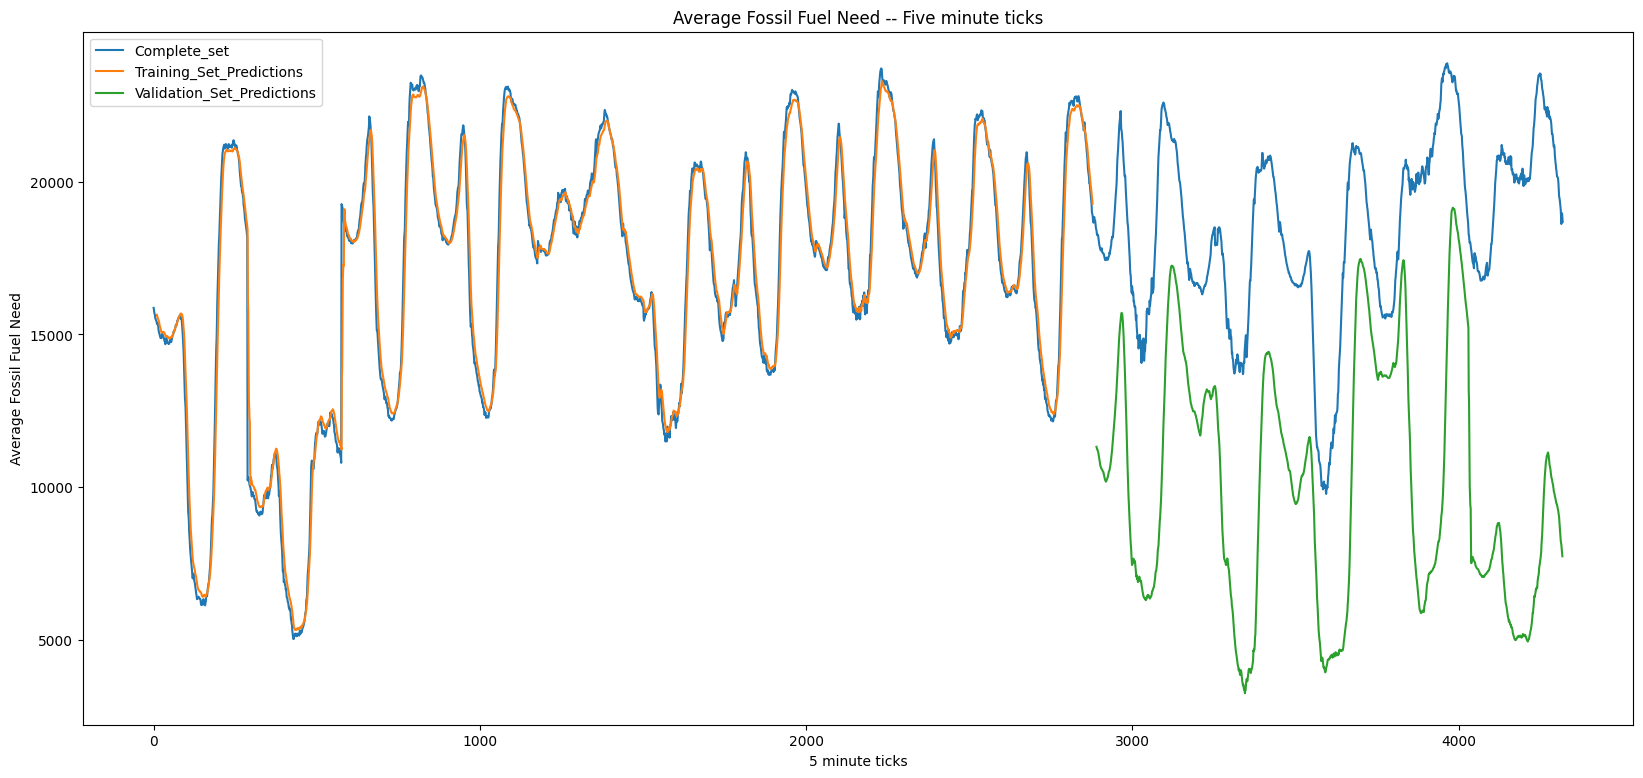

In [63]:
# shift train predictions for plotting
complete_set = complete_set[:slice_point+(5*288)]
trainPredictPlot = np.empty_like(complete_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(trainPredict) + look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(complete_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1: len(complete_set) - 1, :] = validationPredict
# # plot baseline and predictions
plt.figure(figsize=(20,9))
plt.title('Average Fossil Fuel Need -- Five minute ticks')
plt.xlabel('5 minute ticks')
plt.ylabel('Average Fossil Fuel Need')
plt.plot(scaler.inverse_transform(complete_set))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Complete_set', 'Training_Set_Predictions', 'Validation_Set_Predictions'])
plt.show()